In [55]:
# ammend DHS index annotations by doing a down-lift from hg38 to hg19
# First collect positions that could not be downlifted
import collections
blackdict = collections.defaultdict(lambda: False)
errfile = "/cbscratch/franco/datasets/DHSindex/hglft_genome_32b00_ea89f0.err"
with open(errfile) as instream:
    for line in instream:
        if line[0] == "#":
            continue
        blackdict[line.rstrip()] = True

# Go line by line through DHSindex and check if the range was downlifted or not
# and keep its annotation
liftfile = "/cbscratch/franco/datasets/DHSindex/hglft_genome_32b00_ea89f0.bed"
dhsindexfile = "/cbscratch/franco/datasets/DHSindex/DHS_Index_and_Vocabulary_hg38_WM20190703.txt"
hg19_dhs_dict = collections.defaultdict(dict)
hglft = open(liftfile)
with open(dhsindexfile) as instream:
    next(instream)
    for line in instream:
        arr = line.rstrip().split("\t")
        chrm = arr[0]
        start = arr[1]
        end   = arr[2]
        annot = arr[9]
        key = "{:s}:{:s}-{:s}".format(chrm, start, end)
        if not blackdict[key]:
            hg19chrom, hg19range = hglft.readline().rstrip().split(":")
            hg19_dhs_dict[hg19chrom][hg19range] = annot

# Write down the newly annotated dictionary in a file, sorted by genomic position
hg19_DHS_outfile = "/cbscratch/franco/datasets/DHSindex/DHS_Index_downlift_hg19.txt"
with open(hg19_DHS_outfile, 'w') as outstream:
    for chrm in range(1, 23):
        chrom = "chr"+str(chrm)
        for key in sorted(hg19_dhs_dict[chrom], key=lambda t: int(t.split("-")[0])):
            # print(chrom, key, hg19_dhs_dict[chrom][key])
            outstream.write("{:s}\t{:s}\t{:s}\t{:s}\n".format(chrom, key.split("-")[0], key.split("-")[1], hg19_dhs_dict[chrom][key]))

In [177]:
import time
# here we annotate the best trans-eQTLs for EQTLgen

basedir = "/cbscratch/franco/datasets/EQTLgen/"
eqtlgen_gtfile = basedir + "trans-eQTLs_CHR{:d}"
dhsfile = "/cbscratch/franco/datasets/multi-tissue.master.ntypes.simple.hg19.bed"
eqtlgen_annot_outfile = basedir + "SNPs_annots.txt"

def annotate_snps(dhsfile, gtfile, annot_outfile):
    current_chrm = None
    dhs = open(dhsfile)
    line = dhs.readline()
    f = None
    with open(annot_outfile, 'w') as outf:
        outf.write("chr\trsid\tpos\n")
        while line:
            arr = line.rstrip().split()
            if arr[0][3:] == "X":
                break
            chrm = int(arr[0][3:])
            start = int(arr[1])
            end = int(arr[2])
            if chrm != current_chrm:
                if f:
                    f.close()
                # close previous GT file and open new one
                if current_chrm is not None:
                    tend = time.time()
                    print("CHR{:d} took {:g}s".format(current_chrm, tend-tstart))

                current_chrm = chrm
                if not os.path.exists(gtfile.format(current_chrm)):
                    continue
                print("Processing CHRM", current_chrm, end=" ")
                f = open(gtfile.format(current_chrm), 'r')
                next(f)
                tstart = time.time()
                gtline = f.readline()
            if not gtline:
                line = dhs.readline()
            while gtline:
                gtarr = gtline.split()
                rsid = gtarr[0]
                pos = int(gtarr[1])
                # print(rsid, pos, start, end)
                if pos < start:
                    gtline = f.readline()
                    continue # go to next snp
                elif pos > end:
                    line = dhs.readline()
                    break # go to next DHS line
                else:
                    # print("-->",chrm, rsid, pos, start, end)
                    outf.write("{:d}\t{:s}\t{:d}\n".format(chrm, rsid, pos))
                    gtline = f.readline()
                    continue
        if f:
            f.close()
            tend = time.time()
            print("CHR{:d} took {:g}s".format(current_chrm, tend-tstart))
        print("Done DHS file")
        
annotate_snps(dhsfile, eqtlgen_gtfile, eqtlgen_annot_outfile)

Processing CHRM 1 CHR1 took 0.600071s
Processing CHRM 10 CHR10 took 0.340405s
Processing CHRM 11 CHR11 took 0.350172s
Processing CHRM 12 CHR12 took 0.327426s
Processing CHRM 13 CHR13 took 0.183003s
Processing CHRM 14 CHR14 took 0.219912s
Processing CHRM 15 CHR15 took 0.223634s
Processing CHRM 16 CHR16 took 0.233926s
Processing CHRM 17 CHR17 took 0.296864s
Processing CHRM 18 CHR18 took 0.175278s
Processing CHRM 19 CHR19 took 0.211292s
Processing CHRM 2 CHR2 took 0.58323s
Processing CHRM 20 CHR20 took 0.219778s
Processing CHRM 21 CHR21 took 0.0996192s
Processing CHRM 22 CHR22 took 0.14455s
Processing CHRM 3 CHR3 took 0.440485s
Processing CHRM 4 CHR4 took 0.331786s
Processing CHRM 5 CHR5 took 0.403265s
Processing CHRM 6 CHR6 took 0.440814s
Processing CHRM 7 CHR7 took 0.396695s
Processing CHRM 8 CHR8 took 0.361523s
Processing CHRM 9 CHR9 took 0.314937s
Done DHS file


In [ ]:
# TODO: first I need to report snp positions in matrixeqtl output..

def matrixeqtl(filepath, limit=2000):
    res = dict()
    counter = 0
    with open(filepath, 'r') as mfile:
        next(mfile)
        for line in mfile:
            arr  = line.strip().split("\t")
            rsid = arr[0]
            pval = float(arr[4])
            if rsid.get(res, False):
                res[rsid] = pval
            counter += 1
            if counter > limit;
                break
    return np.array(list(res.values()))

def matrixeqtl_fdr(filepath, limit=2000):
    res = dict()
    counter = 0
    with open(filepath, 'r') as mfile:
        next(mfile)
        for line in mfile:
            arr  = line.strip().split("\t")
            rsid = arr[0]
            fdr  = float(arr[5])
            if rsid.get(res, False):
                res[rsid] = fdr
            counter += 1
            if counter > limit;
                break
    return np.array(list(res.values()))


In [158]:
import time
import numpy as np
import os
# here we only try to annotate the best trans-eQTLs only!

randmethods = ["tejaas_rand_"+str(i) for i in np.arange(1,51)]
methods = ["tejaas", "tejaas_rand"] #+ randmethods


for method in methods:
    print("METHOD:", method)
    basedir = "/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v6_dynamic_knn30/tmm/gtex-ms/"+method+"/permnull_sb0.05/"
    gtfile = basedir + "chr{:d}/rr.txt.ld_prune"
    dhsfile = "/cbscratch/franco/datasets/multi-tissue.master.ntypes.simple.hg19.bed"
#     dhsfile = "/cbscratch/franco/datasets/DHSindex/DHS_Index_downlift_hg19.txt"
    annot_outfile = basedir + "SNPs_annots.txt"

    annotate_snps(dhsfile, gtfile, annot_outfile)


METHOD: tejaas
Processing CHRM 1 CHR1 took 0.747034s
Processing CHRM 10 CHR10 took 0.416966s
Processing CHRM 11 CHR11 took 0.406811s
Processing CHRM 12 CHR12 took 0.385013s
Processing CHRM 13 CHR13 took 0.229064s
Processing CHRM 14 CHR14 took 0.261418s
Processing CHRM 15 CHR15 took 0.271528s
Processing CHRM 16 CHR16 took 0.296545s
Processing CHRM 17 CHR17 took 0.324762s
Processing CHRM 18 CHR18 took 0.208882s
Processing CHRM 19 CHR19 took 0.232593s
Processing CHRM 2 CHR2 took 0.670524s
Processing CHRM 20 CHR20 took 0.238703s
Processing CHRM 21 CHR21 took 0.109316s
Processing CHRM 22 CHR22 took 0.16766s
Processing CHRM 3 CHR3 took 0.549901s
Processing CHRM 4 CHR4 took 0.404951s
Processing CHRM 5 CHR5 took 0.465314s
Processing CHRM 6 CHR6 took 0.455661s
Processing CHRM 7 CHR7 took 0.437098s
Processing CHRM 8 CHR8 took 0.407667s
Processing CHRM 9 CHR9 took 0.334368s
Done DHS file
METHOD: tejaas_rand
Processing CHRM 1 CHR1 took 0.707011s
Processing CHRM 10 CHR10 took 0.414406s
Processing C

In [176]:
import mpmath
import collections
import numpy as np

mpmath.mp.dps = 500
def pval(x): return float(mpmath.log10(1 - 0.5 * (1 + mpmath.erf(x/mpmath.sqrt(2)))))

SNPRES_FIELDS = ['rsid', 'chrom', 'pos', 'logp', 'inDHS']
class SNPRes(collections.namedtuple('_SNPRes', SNPRES_FIELDS)):
    __slots__ = ()
       
def eqtlgen(filepath, chrom, snpannot):
    res = list()
    with open(filepath, 'r') as mfile:
        next(mfile)
        for line in mfile:
            arr   = line.strip().split("\t")
            rsid  = arr[0]
            pos   = int(arr[1])
            p     = float(arr[2])
            logp  = np.log10(p) if p != 0 else -99
            inDHS = snpannot.get(rsid, False)
            res.append(SNPRes(rsid=rsid, chrom=chrom, pos=pos, logp=-logp, inDHS=inDHS))
    return res
        
def tejaas(filepath, chrom, snpannot):
    res = list()
    with open(filepath, 'r') as mfile:
        next(mfile)
        for line in mfile:
            arr   = line.strip().split("\t")
            rsid  = arr[0]
            pos   = int(arr[1])
            p     = float(arr[5])
            q     = float(arr[2])
            mu    = float(arr[3])
            sigma = float(arr[4])
            if sigma == 0:
                continue
            logp  = np.log10(p) if p != 0 else pval( (q - mu) / sigma)
            inDHS = snpannot.get(rsid, False)
            res.append(SNPRes(rsid=rsid, chrom=chrom, pos=pos, logp=-logp, inDHS=inDHS))
    return res

In [160]:
import os

def read_annot(infile):
    annot_dict = dict()
    with open(infile) as fin:
        _ = fin.readline()
        for line in fin:
            arr = line.rstrip().split()
            annot_dict[arr[1]] = True
    return annot_dict

datadir = "/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v6_dynamic_knn30/"
chrms = np.arange(1,23)
snp_res_dict = collections.defaultdict(dict)
snp_res_dict_top = collections.defaultdict(dict)
tissues = ["gtex-ms"]
expressions = ["tmm"] #, "lmcorrected_age", "peer/20/covar_withage"]
sbs = ["0.05"]
randmethods = ["tejaas_rand_"+str(i) for i in np.arange(1,51)]
methods = ["tejaas", "tejaas_rand"] # + randmethods
LD = True
for sb in sbs:
    for expr in expressions:
        snp_res_dict[sb][expr] = collections.defaultdict(dict)
        snp_res_dict_top[sb][expr] = collections.defaultdict(dict)
        for tissue in tissues:
            snp_res_dict[sb][expr][tissue] = collections.defaultdict(dict)
            snp_res_dict_top[sb][expr][tissue] = collections.defaultdict(dict)
            for method in methods:
                snp_res = list()
                snp_res_top = list()
                print(tissue, method, expr, end=" ")
                annotfile = os.path.join(datadir,expr,tissue,method,"permnull_sb0.05","SNPs_annots.txt")
                snp_annot = read_annot(annotfile)
                for chrom in chrms:
                    print(chrom, end=" ")
                    inputfile = os.path.join(datadir,expr,tissue,method,"permnull_sb0.05","chr"+str(chrom),"rr.txt.ld_prune")
                    snp_res += tejaas(inputfile, chrom, snp_annot)

#                     if LD:
#                         inputfile = inputfile = os.path.join(datadir,expr,tissue,method,"permnull_sb0.05","chr"+str(chrom),"rr.txt.ld.new.top2000")
#                     else:
#                         inputfile = os.path.join(datadir,expr,tissue,method,"permnull_sb0.05","chr"+str(chrom),"rr.txt.top2000")
#                     snp_res_top += tejaas(inputfile, chrom, snp_annot)
                print("")
                snp_res_dict[sb][expr][tissue][method] = snp_res
#                 snp_res_dict_top[sb][expr][tissue][method] = snp_res_top



gtex-ms tejaas tmm 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
gtex-ms tejaas_rand tmm 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 


In [179]:
eqtlgen_snp_annot = read_annot(eqtlgen_annot_outfile)
eqtlgen_snp_res = list()
for chrom in chrms:
    eqtlgen_snp_res += eqtlgen(eqtlgen_gtfile.format(chrom), chrom, eqtlgen_snp_annot)

In [197]:
from operator import attrgetter

MAX_TOP = 2000
TOP_W = 100
mytissue = "gtex-ms"
mysb = "0.05"
myexpr = "tmm"
mymethod = "tejaas"
snp_list = snp_res_dict[mysb][myexpr][mytissue][mymethod]
top_list = sorted(snp_list, key=attrgetter('logp'), reverse=True)

eqtlgen_top_list = sorted(eqtlgen_snp_res, key=attrgetter('logp'), reverse=True)

x = np.array([])
y = np.array([])
ygen = np.array([])

wx = np.array([])
wy = np.array([])
wygen = np.array([])

eqtlgen_true = 0
true_eqtls = 0
rand_eqtls = 0

prev = 0
for TOPN in range(TOP_W, MAX_TOP, TOP_W):
    
    window_true_eqtls = np.sum([x.inDHS for x in top_list[prev:TOPN]])
    true_eqtls += window_true_eqtls

    rand_distrib = []
    # myrandmethods = ["tejaas_rand"] # + randmethods
    # for mymethod in myrandmethods:
    myrandmethod = "tejaas_rand"
    snp_list_rand = snp_res_dict[mysb][myexpr][mytissue][myrandmethod]
    top_list_rand = sorted(snp_list_rand, key=attrgetter('logp'), reverse=True)
      
    window_eqtlgen_true = np.sum([x.inDHS for x in eqtlgen_top_list[prev:TOPN]])
    eqtlgen_true += window_eqtlgen_true
    
    window_rand_eqtls = np.sum([x.inDHS for x in top_list_rand[prev:TOPN]])
    rand_eqtls += window_rand_eqtls

    print(true_eqtls, rand_eqtls, true_eqtls/rand_eqtls, "||", eqtlgen_true, eqtlgen_true/rand_eqtls, window_eqtlgen_true, window_eqtlgen_true/window_rand_eqtls)
    x = np.append(x, TOPN)
    y = np.append(y, true_eqtls/rand_eqtls)
    ygen = np.append(ygen, eqtlgen_true/rand_eqtls)
    
    wx = np.append(wx, TOPN)
    wy = np.append(wy, window_true_eqtls/window_rand_eqtls)
    wygen = np.append(wygen, window_eqtlgen_true/window_rand_eqtls)
    prev += TOP_W


19 14 1.3571428571428572 || 60 4.285714285714286 60 4.285714285714286
36 29 1.2413793103448276 || 89 3.0689655172413794 29 1.9333333333333333
63 46 1.3695652173913044 || 128 2.782608695652174 39 2.2941176470588234
85 64 1.328125 || 167 2.609375 39 2.1666666666666665
109 74 1.472972972972973 || 194 2.6216216216216215 27 2.7
128 90 1.4222222222222223 || 225 2.5 31 1.9375
145 103 1.4077669902912622 || 259 2.5145631067961167 34 2.6153846153846154
162 118 1.3728813559322033 || 293 2.483050847457627 34 2.2666666666666666
181 132 1.371212121212121 || 318 2.409090909090909 25 1.7857142857142858
201 148 1.3581081081081081 || 344 2.324324324324324 26 1.625
227 169 1.3431952662721893 || 368 2.1775147928994083 24 1.1428571428571428
242 186 1.3010752688172043 || 393 2.1129032258064515 25 1.4705882352941178
264 202 1.306930693069307 || 423 2.094059405940594 30 1.875
279 213 1.3098591549295775 || 454 2.131455399061033 31 2.8181818181818183
294 231 1.2727272727272727 || 488 2.1125541125541125 34 1.888

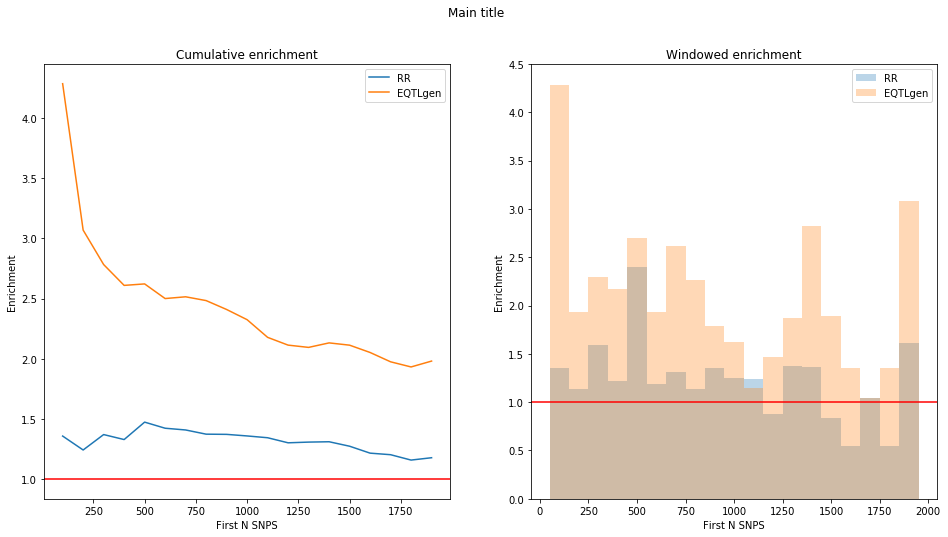

In [196]:
import matplotlib.pyplot as plt
outplotfile = "test.dhs.png"

fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(x, y, label="RR")
ax1.plot(x, ygen, label="EQTLgen")
ax1.set_title("Cumulative enrichment")
ax1.axhline(y=1, color='red')

ax2.bar(wx, wy, 100, alpha=0.3, label="RR")
ax2.bar(wx, wygen, 100, alpha=0.3, label="EQTLgen")
ax2.axhline(y=1, color='red')
ax2.set_title("Windowed enrichment")

ax1.set_xlabel("First N SNPS")
ax2.set_xlabel("First N SNPS")
ax1.set_ylabel("Enrichment")
ax2.set_ylabel("Enrichment")

fig.suptitle('Main title')
ax1.legend()
ax2.legend()

# fig.tight_layout()
# fig.subplots_adjust(top=0.88)
plt.savefig(outplotfile, bbox_inches='tight')
plt.show()

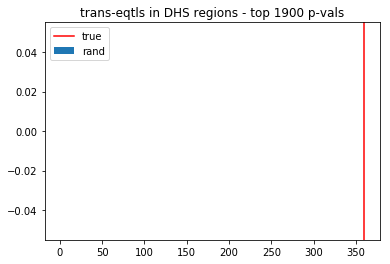

In [126]:
import matplotlib.pyplot as plt

dist = np.array(rand_distrib)
plt.hist(dist, bins=20, label="rand")
plt.axvline(true_eqtls, color="red", label="true")
plt.title("trans-eqtls in DHS regions - top {:d} p-vals".format(TOPN))
plt.legend()
plt.show()